In [2]:
import argparse
import os
import random
import shutil
import time
import warnings
import json
import re

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms

from model_analysis_nets import *
from CKA import linear_CKA, kernel_CKA

import numpy as np
import sympy
import pandas
import seaborn

import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, fclusterdata
import scipy

In [3]:
def getGradients(modelpth : str = ""):
    if not modelpth:
        return {}
    model1 = LeNet().to(device)
    model1.load_state_dict(torch.load(modelpth))
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model1.parameters(), lr=0.01, momentum=0.5)

    for X, Y in test_loader:
        X_test = X.to(device)
        Y_test = Y.to(device)
        # print(Y)
        break

    # Forward pass
    outputs = model1(X_test)

    # Compute the loss
    loss = criterion(outputs, Y_test)

    # Zero the gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Access the gradients
    gradients1 = {}
    for name, param in model1.named_parameters():
        gradients1[name] = param.grad
    return gradients1

In [4]:
trans_mnist = transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize((0.1307,), (0.3081,))])
dataset_test = datasets.MNIST('data/mnist/', train=False, download=True, transform=trans_mnist)
test_loader = torch.utils.data.DataLoader(
                dataset_test, batch_size=32,
                num_workers=2, pin_memory=True, shuffle=False)

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
attack_pth = "../TDA-NN/3090/LG-FedAvg/save_attack_ub/mnist/lenet_iidTrue_num100_C0.8_le2/shard2/pattern11-30--17-49-20/local_attack_save/"
normal_pth = "../TDA-NN/3090/LG-FedAvg/save_attack_ub/mnist/lenet_iidTrue_num100_C0.8_le2/shard2/pattern11-30--17-49-20/local_normal_save/"

In [7]:
modelpth_set = []
round_max = 15
client_max = 50
for dirpath, dirnames, filenames in os.walk(attack_pth):
    # Do something with the files or directories found
    for filename in filenames:
        # print(os.path.join(dirpath, filename).replace("\\","/"))
        # if int(re.findall("\d+\.?\d*", filename)[0]) < round_max:
        if int(re.findall(r'-?\d+', filename)[0]) < round_max and int(re.findall(r'-?\d+', filename)[1]) < client_max:
            modelpth_set.append(os.path.join(dirpath, filename).replace("\\","/"))
attacks = len(modelpth_set)
print(len(modelpth_set))
for dirpath, dirnames, filenames in os.walk(normal_pth):
    # Do something with the files or directories found
    for filename in filenames:
        # print(os.path.join(dirpath, filename).replace("\\","/"))
        if int(re.findall(r'-?\d+', filename)[0]) < round_max and int(re.findall(r'-?\d+', filename)[1]) < client_max:
            modelpth_set.append(os.path.join(dirpath, filename).replace("\\","/"))

print(len(modelpth_set))
normals = len(modelpth_set) - attacks

66
99


In [8]:
corr_depth = 1
# model = LeNet().to(device)
# model.load_state_dict(torch.load(modelpth_set[0]))
# for name, w in model.named_parameters():
#             if "weight" in name:
#                 corr_depth += 1

corr_max = normals + attacks
corr = np.zeros((corr_max, corr_max, corr_depth))

gradientlist = []
for idx, modelp1 in enumerate(modelpth_set):
    gradientlist.append(getGradients(modelp1))

print(len(gradientlist))

for id1, modelp1 in enumerate(gradientlist):
    if id1 >= corr_max:
        break
    for id2, modelp2 in enumerate(gradientlist):
        if id2 >= corr_max:
            break
        if id2 <= id1:
            continue
        gradients1 = gradientlist[id1]
        gradients2 = gradientlist[id2]
        
        corrlist = []
#         for w in gradients1.keys():
#             if "weight" in w:
#                 acts1 = gradients1[w]
#                 acts2 = gradients2[w]
#                 # print("activation shapes", acts1.shape, acts2.shape)
#                 factors = sympy.factorint(acts1.reshape(-1,1).shape[0])
#                 # f = factors.items()[-1]
#                 f = int(sorted(factors.keys())[-1]) ** (factors[sorted(factors.keys())[-1]]-1)
                
#                 acts1 = acts1.cpu().reshape((f,-1))
#                 acts2 = acts2.cpu().reshape((f,-1))
#                 l = linear_CKA(acts1.T, acts2.T)
#                 k = kernel_CKA(acts1.T, acts2.T)
#                 # print('Linear CKA: {}'.format(l))
#                 # print('RBF Kernel: {}'.format(k))
#                 corrlist.append((l+k)/2)
        acts1 = gradients1["layer3.0.weight"]
        acts2 = gradients2["layer3.0.weight"]
        acts1 = acts1.cpu().reshape((50,-1))
        acts2 = acts2.cpu().reshape((50,-1))
        l = linear_CKA(acts1.T, acts2.T)
        k = kernel_CKA(acts1.T, acts2.T)
        corrlist.append((l+k)/2)
        # print(corrlist)
                
        corr[id1][id2] = np.array(corrlist)


Traceback (most recent call last):
  File "/opt/conda/envs/torch/lib/python3.8/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/opt/conda/envs/torch/lib/python3.8/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/opt/conda/envs/torch/lib/python3.8/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/opt/conda/envs/torch/lib/python3.8/shutil.py", line 722, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/opt/conda/envs/torch/lib/python3.8/shutil.py", line 720, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-jr0npsr6'


99


In [9]:
corr.reshape(-1,99).shape

(99, 99)

In [10]:
print(scipy.spatial.distance.squareform(corr.reshape(-1,99) + corr.reshape(-1,99).T))

[0.73965014 0.83576795 0.89839166 ... 0.88712896 0.81569855 0.90342335]


In [16]:
Z = linkage(1 - (corr.reshape(-1,99) + corr.reshape(-1,99).T), 'ward')
# Z = linkage(scipy.spatial.distance.squareform(corr.reshape(-1,99) + corr.reshape(-1,99).T), 'ward')


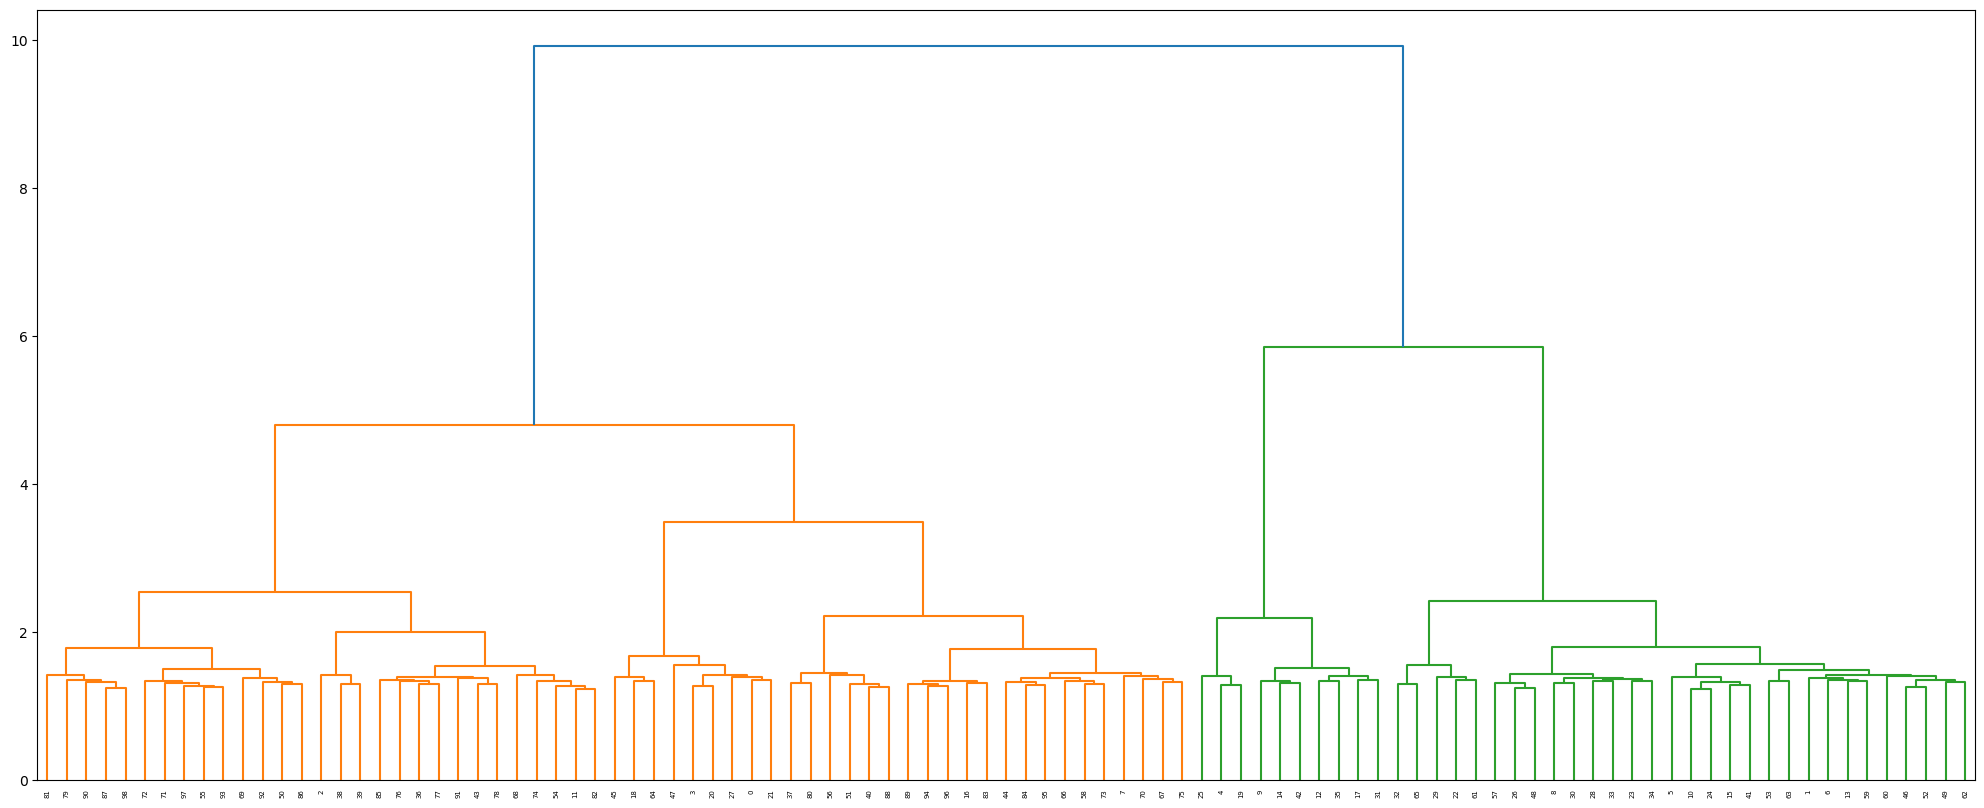

In [17]:
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)
plt.show()

In [21]:
max_d = 4
clusters = fcluster(Z, max_d, criterion='distance')
print(clusters)
unique_arr = list(set(clusters))
print(unique_arr)

[2 4 1 2 3 4 4 2 4 3 4 1 3 4 3 4 2 3 2 3 2 2 4 4 4 3 4 2 4 4 4 3 4 4 4 3 1
 2 1 1 2 4 3 1 2 2 4 2 4 4 1 2 4 4 1 1 2 4 2 4 4 4 4 4 2 4 2 2 1 1 2 1 1 2
 1 2 1 1 1 1 2 1 1 2 2 1 1 1 2 2 1 1 1 1 2 2 2 1 1]
[1, 2, 3, 4]


In [19]:
f = 2
count = np.count_nonzero(clusters == f)
print(f"cata = {1},",count)

cata = 1, 30


In [22]:
for u in unique_arr:
    cluster_indices = [i for i, x in enumerate(clusters) if x == u]
    cluster_values = [i+1 for i in cluster_indices]
    average_cluster_u = sum(cluster_values) / len(cluster_values)
    print(u, average_cluster_u)

1 69.06896551724138
2 54.8
3 21.8
4 36.166666666666664


/tmp/ipykernel_280345/2637727204.py:5: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(X, 'single')


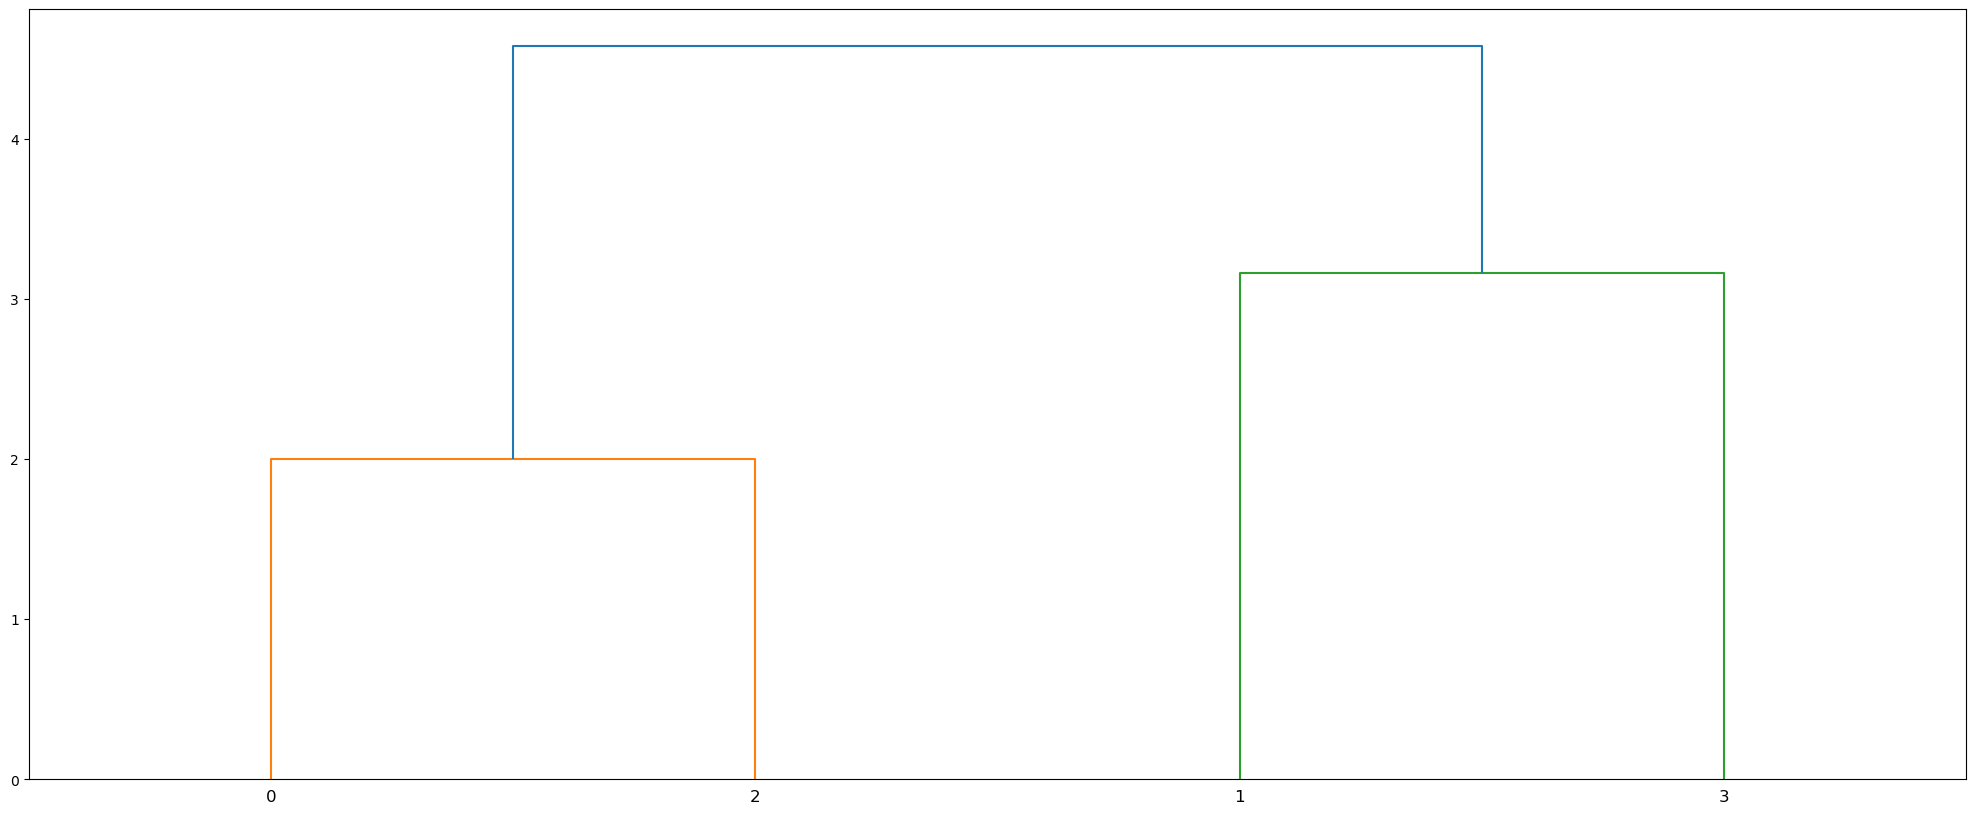

In [15]:
X = np.array([[0, 2, 1, 4],
              [2, 0, 3, 1],
              [1, 3, 0, 5],
              [4, 1, 5, 0]])
Z = linkage(X, 'single')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)
plt.show()